# Importing libraries

In [0]:
%load_ext rpy2.ipython

In [2]:
%%R
install.packages("grf")



/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: also installing the dependencies ‘zoo’, ‘DiceKriging’, ‘lmtest’, ‘sandwich’, ‘RcppEigen’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cran.rstudio.com/src/contrib/zoo_1.8-7.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 861309 bytes (841 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:1

In [3]:
!pip install justcause

     |████████████████████████████████| 51kB 518kB/s 
     |████████████████████████████████| 1.8MB 13.3MB/s 
     |████████████████████████████████| 3.5MB 49.6MB/s 
     |████████████████████████████████| 276kB 59.5MB/s 
  Created wheel for causalml: filename=causalml-0.7.0-cp36-cp36m-linux_x86_64.whl size=471483 sha256=0f17787516727440541fe91a98f23e1a72e32cf5f92b0c5eb9057d3ced7a3b70
  Stored in directory: /root/.cache/pip/wheels/9a/b4/77/8ab9acc1734668cc9a607b8078702fa213bd138097e5cbc7b2
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394153 sha256=1849b1a0f9c5e980950dbb26c664fbe969761d530ee66f9986ddbcf3ea334119
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built causalml shap


In [0]:
from justcause.data import Col
from justcause.data.sets import load_ihdp
from justcause.metrics import pehe_score, mean_absolute
from justcause.evaluation import calc_scores, summarize_scores

In [0]:
%load_ext autoreload

%autoreload 2

# Loading all required packages 
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#### Infant Health Development Program Data-Set used in this exercise

- Original study constructed to study the effect of special child care for low birthweight, premature infants.
- In total, six continuous and 19 binary pretreatment variables
- Using the covariates of all instances in both treatment groups, the potential outcomes are generated synthetically
- Finally, manipulation of observational study by omitting a non-random set of samples from the treatment group.
- The way the subset is generated from the experimental data does not ensure complete overlap - latent confounder
- Specifically, the observational subset is created by throwing away the set of all children with nonwhite mothers from the treatment group
- Following data generation process used for potentia outcomes
- After the adaptions from Hill, we are left with 139 instances in the treated group and 608 instances in the control group.

# 1. Running the causal models

In [0]:
# We Import the IHDP data-set 
# There are 1000 replications in this data-set, each with a different individual treament effect
# produced from an underlying generative function. 
# Check out https://justcause.readthedocs.io/en/latest/


# We load 100 of the 1000 data-sets
replications = load_ihdp(select_rep=np.arange(100))

In [0]:
# Defining global parameters
train_size = 0.8        # Size of the training data-set 
random_state = 42        # Setting the random state

n= 0       # number of the data-sets we look at 

metrics = [pehe_score, mean_absolute]    ## Defining the metrics that will be calculated below

## 1.1 S-Learner Linear Regression

In [0]:
# Importing the relevant SLearner module

from justcause.learners import SLearner


# Defining the S-Learner function that returns the ITE
# We define a function that takes the data, splits it up and returns individual treatment effect accuracies for the train and the test data-set
# The function takes each, the train and test data separately and selects the relevant variales and coverts them into np arrays
# The relevant variables have the followings names: x (the covariates), t (the treatment), y (the outcome)
# Note that the treatment needs to be explicityl defined



def basic_slearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    slearner = model     # Select linear regression as a method to find the ITE for the S-Learner
    slearner.fit(train_X, train_t, train_y)      # Fitting the s-learner with linear regression
    return (
        slearner.predict_ite(train_X, train_t, train_y),   # Returning the predicting values for ITE for train
        slearner.predict_ite(test_X, test_t, test_y)       # Returning the prediction values for ITE for test
    )



In [0]:
results_df = list()     # We define the list that contains the results
test_scores = list()    # Storing the test scores in a list
train_scores = list()   # Storing the train scores in a list


# Here we define the model that is going to be used for the S-learner
# Please instantiate linear regression for the simple learner


##-----------------Question------------------###
# Pass a LinearRegression Model into the S-Learner
# No particular parameter-settings necessary
from sklearn.linear_model import LinearRegression

lreg =  LinearRegression()

model=SLearner(lreg)


for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_slearner(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'S-Learner LR', 'train': True})
test_result.update({'method': 'S-Learner LR', 'train': False})

In [10]:
df_S_learner_LR=pd.DataFrame([train_result, test_result])
df_S_learner_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.633660,2.623297,8.362125,0.732443,0.238185,1.493276,S-Learner LR,True
1,5.625971,2.635993,8.213626,1.292668,0.396246,2.474603,S-Learner LR,False


### 1.1.1 S-Learner Visualization

In [0]:
# We run the same analysis again but only on an indvidual run of the data
# The reason is that the data generating process is varied every time,... 
# ...so we can only look at individual runs of the ITE effect
results_df = list()    # We define the list that contains the results
test_scores = list()   # Storing the test scores in a list
train_scores = list()  # Storing the train scores in a list


#for rep in replications:

train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state     # Use train_test_split  to split the data-set (replications[n]) 
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = basic_slearner(train, test, model)         # using the pre-defined basic learner function to retunr train, test

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))    # Using the just cause API to calcualte the scores from the estimate ITE for the training data
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))     # Using the just cause API to calcualte the scores from the estimate ITE for the test data

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)   #summary of the scores 
train_result.update({'method': 'S-Learner LR', 'train': True})
test_result.update({'method': 'S-Learner LR', 'train': False})


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


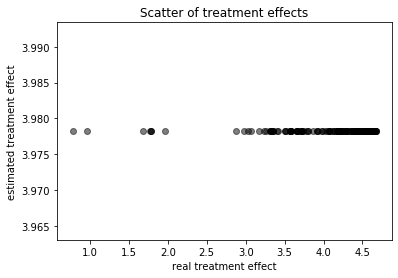

In [12]:
# Importing Matplotlib 
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

# If the treatment effect is perfectly represented there should be a 45 degree line!

## QUESTION 1

IS THE S-LEARNER WITH LINEAR REGRESSION ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# Answer 1: #

The propensity score matching(PSM) which is a popular tool to estimate causal effects in observational studies shows not so good results when used with Linear Regression as a model. The reason for coming to such a conclusion is the lack of heterogenous treatment effects that the model can show as the avergae treatment effect is fixed; which could be determined by the horizontal line in the graph and by the pehe-mean score.

## 1.2 Propensity Score Weighing with Linear Regression

In [0]:
# Importing the relevant PSWEstimator

from justcause.learners import PSWEstimator


#Defining the Propoensity Score weighing function that returns the ITE

def propensity_score_weighing(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    pswestimator = model

    return (
        pswestimator.estimate_ate(train_X, train_t, train_y),
        pswestimator.estimate_ate(test_X, test_t, test_y)
    )


In [0]:
results_df = list()
test_scores = list()
train_scores = list()




model = PSWEstimator(propensity_learner=None, delta=0.001)


for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = propensity_score_weighing(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'PSW', 'train': True})
test_result.update({'method': 'PSW', 'train': False})

In [15]:
df_PSW_LR=pd.DataFrame([train_result, test_result])
df_PSW_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.595322,2.537818,8.244302,0.412006,0.284332,0.457697,PSW,True
1,6.837997,3.484394,8.323623,3.783440,2.649187,3.225824,PSW,False


## 1.3 S-Learner Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


# Importing the relevant S-Learner estimator
from justcause.learners import SLearner


#Defining the S-Learner function that returns the ITE

def basic_slearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    slearner = model  
    slearner.fit(train_X, train_t, train_y)
    return (
        slearner.predict_ite(train_X, train_t, train_y),
        slearner.predict_ite(test_X, test_t, test_y)
    )


In [0]:
results_df = list()
test_scores = list()
train_scores = list()

#---------------------------Question--------------------------------#
# Pass a RandomForestRegressor into the S-learner

rreg = RandomForestRegressor()

model = SLearner(rreg)

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_slearner(train, test, model )

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'S-Learner RF', 'train': True})
test_result.update({'method': 'S-Learner RF', 'train': False})

In [18]:
df_S_learner_RF=pd.DataFrame([train_result, test_result])
df_S_learner_RF

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,3.105397,1.050890,4.766095,0.500324,0.133818,0.928113,S-Learner RF,True
1,3.319565,1.273795,5.171689,0.446731,0.133490,1.027640,S-Learner RF,False


### 1.3.1 Random Forest Visualization

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


# Importing the relevant SLearner module
from justcause.learners import SLearner


#Defining the S-Learner function that returns the ITE

def basic_slearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    slearner = model
    slearner.fit(train_X, train_t, train_y)
    return (
        slearner.predict_ite(train_X, train_t, train_y),
        slearner.predict_ite(test_X, test_t, test_y)
    )

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


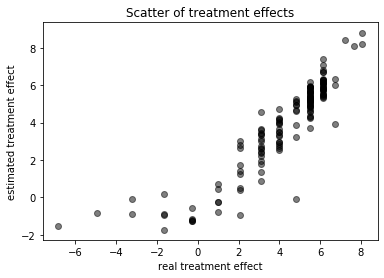

In [20]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## QUESTION 2

IS THE S-LEARNER WITH RANDOM FOREST ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# Answer 2 #

In comparison to the training of S-Learner with 'Linear Regression' as a model, the S-Learner trained with 'Random Forest' as a model shows better results. The heterogenity of the treatment effect is captured which can be observed in the graph and the pehe scores. The distribution between the real time and estimated treatment effects increases linearly, indicating with a high estimated treatment effect the real-time effect is also high. Hence, the model is not optimum as the S-learner is used on the estimators in the model and the treatment effects are handled as a feature, as all the other features are getting handled the treatment effects feature doesn't get assigned any role.

## 1.4 T-Learner Linear Regression

In [0]:
# Importing the relevant SLearner module

from justcause.learners import TLearner


#Defining the S-Learner function that returns the ITE

def basic_tlearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    tlearner = model
    tlearner.fit(train_X, train_t, train_y)
    return (
        tlearner.predict_ite(train_X, train_t, train_y),
        tlearner.predict_ite(test_X, test_t, test_y)
    )



In [0]:
results_df = list()
test_scores = list()
train_scores = list()

#------------------Question------------------------------#
# Pass linear regression into the T-Learner



model = TLearner(lreg)

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_tlearner(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner LR', 'train': True})
test_result.update({'method': 'T-Learner LR', 'train': False})

In [23]:
df_T_learner_LR=pd.DataFrame([train_result, test_result])
df_T_learner_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,2.276868,1.055409,3.319402,0.149960,0.133955,0.129121,T-Learner LR,True
1,2.337753,1.122464,3.263915,0.263287,0.195850,0.327846,T-Learner LR,False


### 1.4.1 T-Learner Linear Regression Visualization

In [0]:
results_df = list()
test_scores = list()
train_scores = list()

train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = basic_tlearner(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner LR', 'train': True})
test_result.update({'method': 'T-Learner LR', 'train': False})

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


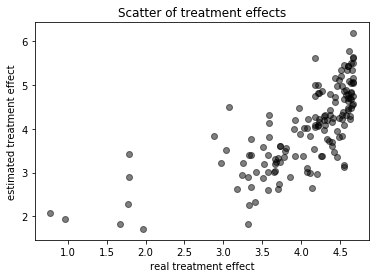

In [25]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## QUESTION 3

IS THE T-LEARNER WITH LINEAR REGRESSION ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# Answer 3 #

The T-Learner trained on Linear Regression is even not the optimum one in estimating the individual treatment effects well as the density of the graph is high around the 4.0-4.5 area of the real treatment effect. Irrespective of the low or high value of the estimated treatment effect the real treatment effect tends to be high.

## 1.5 T-Learner Random Forest

In [0]:
# Importing the relevant SLearner module

from justcause.learners import TLearner


#Defining the S-Learner function that returns the ITE

def basic_tlearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    tlearner = model
    tlearner.fit(train_X, train_t, train_y)
    return (
        tlearner.predict_ite(train_X, train_t, train_y),
        tlearner.predict_ite(test_X, test_t, test_y)
    )



In [0]:
results_df = list()
test_scores = list()
train_scores = list()

#--------------------Question----------------------------------#
# Pass a Random Forest into the T-Learner

model = TLearner(rreg)

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_tlearner(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

In [28]:
df_T_learner_RF=pd.DataFrame([train_result, test_result])
df_T_learner_RF

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,1.779325,0.953937,2.242132,0.123705,0.094111,0.115848,T-Learner RF,True
1,2.509532,1.112424,3.500381,0.205711,0.118718,0.275564,T-Learner RF,False


### 1.5.1 T-Learner with Random Forrest Visualization

In [0]:
results_df = list()
test_scores = list()
train_scores = list()



train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = basic_tlearner(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


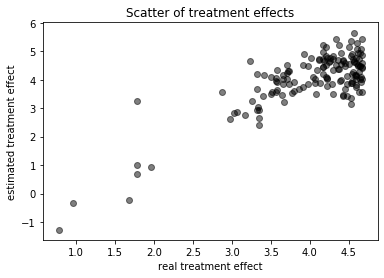

In [30]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## QUESTION 4

IS THE T-LEARNER WITH RANDOM FOREST ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# Answer 4 #

Alternatively, the T-Learner trained on a Random Forest proves to be a good estimator of the individual treatment effect as the symmetry between the real treatment effects and the estimated treatment effects seems to be in line. Hence, low overfitting. This conclusion is also proven by the low pehe-mean score for the training = True part, indicating people receiving the actual treatment.

## 1.6 Causal Forest

In [0]:
# Importing the relevant SLearner module

from justcause.learners import CausalForest


#Defining the S-Learner function that returns the ITE

def causal_forest(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    causalforest = CausalForest(random_state=random_state)
    causalforest.fit(train_X, train_t, train_y)
    return (
        causalforest.predict_ite(train_X, train_t, train_y),
        causalforest.predict_ite(test_X, test_t, test_y)
    )


In [0]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()

model = CausalForest(random_state=random_state)

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = causal_forest(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

In [33]:
df_causal_forest=pd.DataFrame([train_result, test_result])
df_causal_forest

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,4.172661,1.921242,6.330031,0.441738,0.198733,0.823171,T-Learner RF,True
1,4.378083,1.797608,6.606150,0.683703,0.233695,1.354973,T-Learner RF,False


### 1.6.1 Causal Forest Visualization 

In [0]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()



train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = causal_forest(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


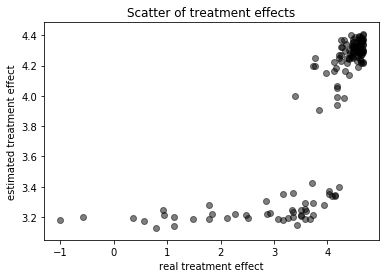

In [35]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## QUESTION 5

IS THE CAUSAL FOREST WITH LINEAR REGRESSION ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# Answer 5 #

The Causal Forest trained on Linear Regression is not a good estimator for estimating individual treatment effects as the graph shows for 4.2-4.4 estimated effect the real effect is also considerably high. Additionally, the pehe-standard deviation is huge 6.3-6.6(approx) for training true and false respectively. Thus, implying the size of the leaves of both treatment and non-treatment are not sufficient. 

## 1.7 Neural Network

In [0]:
# Importing the relevant SLearner module

from justcause.learners import DragonNet


#Defining the S-Learner function that returns the ITE

def causal_forest(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    dragonnet = model
    dragonnet.fit(train_X, train_t, train_y)
    return (
        dragonnet.predict_ite(train_X, train_t, train_y),
        dragonnet.predict_ite(test_X, test_t, test_y)
    )


In [37]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()


#---------------------------Question----------------------------#
# Set the model to the DragonNet neural network from JustCause


model = DragonNet()


for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = causal_forest(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'Dragonnet', 'train': True})
test_result.update({'method': 'Dragonnet', 'train': False})

Using TensorFlow backend.


Streaming output truncated to the last 5000 lines.
Epoch 46/50
537/537 [==============================] - 0s 68us/step - loss: 1620.1696 - regression_loss: 685.2870 - val_loss: 305.1628 - val_regression_loss: 137.9672
Epoch 47/50
537/537 [==============================] - 0s 60us/step - loss: 1600.2654 - regression_loss: 678.7872 - val_loss: 297.1945 - val_regression_loss: 134.0851
Epoch 48/50
537/537 [==============================] - 0s 53us/step - loss: 1556.1100 - regression_loss: 654.1004 - val_loss: 291.7565 - val_regression_loss: 131.3416
Epoch 49/50
537/537 [==============================] - 0s 54us/step - loss: 1503.0106 - regression_loss: 629.7872 - val_loss: 287.8929 - val_regression_loss: 129.3147
Epoch 50/50
537/537 [==============================] - 0s 52us/step - loss: 1497.6454 - regression_loss: 626.4661 - val_loss: 284.1360 - val_regression_loss: 127.3921
***************************** elapsed_time is:  3.286308765411377
Train on 537 samples, validate on 60 samples
Epo

In [38]:
df_dragonnet=pd.DataFrame([train_result, test_result])
df_dragonnet

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,2.831563,1.17451,4.796549,0.829327,0.346305,1.655209,Dragonnet,True
1,2.942670,1.12136,4.701229,0.938807,0.398237,2.062225,Dragonnet,False


### 1.7.1 Neura Network Visualization

In [39]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()



train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = causal_forest(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'Dragonnet', 'train': True})
test_result.update({'method': 'Dragonnet', 'train': False})

Train on 537 samples, validate on 60 samples
Epoch 1/50
537/537 [==============================] - 1s 1ms/step - loss: 14463.6517 - regression_loss: 7055.7229 - val_loss: 1608.2212 - val_regression_loss: 780.8147
Epoch 2/50
537/537 [==============================] - 0s 60us/step - loss: 10493.0339 - regression_loss: 5075.6086 - val_loss: 1046.6842 - val_regression_loss: 500.5428
Epoch 3/50
537/537 [==============================] - 0s 45us/step - loss: 6544.5100 - regression_loss: 3105.4256 - val_loss: 550.2848 - val_regression_loss: 252.8628
Epoch 4/50
537/537 [==============================] - 0s 46us/step - loss: 3293.9217 - regression_loss: 1484.7160 - val_loss: 395.8221 - val_regression_loss: 176.1625
Epoch 5/50
537/537 [==============================] - 0s 43us/step - loss: 3265.9049 - regression_loss: 1475.1438 - val_loss: 375.6133 - val_regression_loss: 166.2253
Epoch 6/50
537/537 [==============================] - 0s 51us/step - loss: 3347.4611 - regression_loss: 1517.2158 - v

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


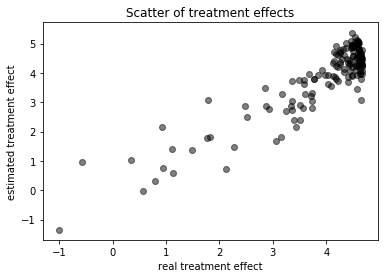

In [40]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## QUESTION 6

IS THE DRAGONNET NEURAL NETWORK ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

# Answer 6 #

The Dragonnet NN proves to be a good estimator for estimating the individual treatment effect as shown by the graph above which shows consistency in prediction for both treatments and non-treatments. There seems to be a good symmetry between high estimated treatment effect having high real treatment effect and vice versa.

## 1.8 Comparison of the methods

In [41]:
pd.concat([df_S_learner_LR, df_PSW_LR, df_S_learner_RF, df_T_learner_LR, df_T_learner_RF, df_causal_forest, df_dragonnet ], ignore_index=True)

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.633660,2.623297,8.362125,0.732443,0.238185,1.493276,S-Learner LR,True
1,5.625971,2.635993,8.213626,1.292668,0.396246,2.474603,S-Learner LR,False
2,5.595322,2.537818,8.244302,0.412006,0.284332,0.457697,PSW,True
3,6.837997,3.484394,8.323623,3.783440,2.649187,3.225824,PSW,False
4,3.105397,1.050890,4.766095,0.500324,0.133818,0.928113,S-Learner RF,True
5,3.319565,1.273795,5.171689,0.446731,0.133490,1.027640,S-Learner RF,False
6,2.276868,1.055409,3.319402,0.149960,0.133955,0.129121,T-Learner LR,True
7,2.337753,1.122464,3.263915,0.263287,0.195850,0.327846,T-Learner LR,False
8,1.779325,0.953937,2.242132,0.123705,0.094111,0.115848,T-Learner RF,True
9,2.509532,1.112424,3.500381,0.205711,0.118718,0.275564,T-Learner RF,False




```
# This is formatted as code
```

## QUESTION 7

HOW DO THE DIFFERENT MODELS COMPARE IN TERMS OF MEAN PEHE ACCURACY? WHAT ASPECTS DO YOU THINK DETERMINE WHETHER ONE MODEL PERFOMS BETTER THAN ANOTER?

# Answer 7 #

By drawing comparison between all the models tested for S-learners and T-learners, the Random forest trained model for T-learner and Dragonnet NN seem to perform best among the lot. Their pehe-scores seems stable, less or no overfitting between both the classes of Training True and False across the said models which to me is a good measure of determination of a good model performance. Additionally, the fact that S-Learner model algorithms use singel supervised learning technique whereas the T-Learner models use two estimators to execute the same task should also be considered while making a decision. Not to forget, the ability of handling hetrogenity by a model also influences its pehe-accuracy scores and in turn their performance.